# Import and define functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import sparse_encode
from pathlib import Path
import pandas as pd
import plotly.express as px
from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal import fftconvolve, oaconvolve
from tqdm import tqdm
from scipy.sparse.linalg import svds
import time
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
def reconstruct_signal(X_mat, signal_length, jump=1):
    N_window = X_mat.shape[0]
    z = np.eye(signal_length, signal_length - N_window + 1)[:, ::jump]
    X_shift = oaconvolve(X_mat, z, mode="full", axes=0)[:signal_length]
    ind_convolve = oaconvolve(np.ones_like(X_mat), z, mode="full", axes=0)[:signal_length]
    X_shift[np.abs(X_shift) < 1e-10] = 0.
    ind_convolve[ind_convolve < 1e-1] = 0.

    X_sum = X_shift.sum(axis=1)
    coefs = (ind_convolve != 0.).sum(axis=1)
    X_sum = X_sum / np.maximum(coefs, 1.)
    return X_sum

In [3]:
def get_trajectory_matrix(arr, window_shape, jump=1):
    return sliding_window_view(x=arr, window_shape=window_shape)[::jump].T

In [191]:
class KSVD:
    def __init__(self, n_nonzero_coefs, K, sparse_coding_solver='omp', max_iter=100, tol=5e-3, parallel=False, **args):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.K = K
        self.max_iter = max_iter
        self.tol = tol
        self.sparse_coding_solver = sparse_coding_solver
        self.dict_errors = []
        self.reconstruction_errors = []
        self.parallel = parallel
    
    def update_column(self, D, Z, X, k):
        # start = time.time()
        z_row = Z[k]
        d_col = D[:, k]
        D_r = np.delete(D, k, axis=1)
        mask_nonzero = z_row != 0.
        if not mask_nonzero.any():
            return d_col, z_row
        Z_r = np.delete(Z[:, mask_nonzero], k, axis=0)
        # t_dict = time.time()
        # print('t_dict', t_dict - start)
        # rank_one_sum =  (D_r[:, None, :] * Z_r.T[None, :, :]).sum(axis=-1)
        rank_one_sum = np.einsum('i...k,...jk', D_r, Z_r.T).reshape(d_col.shape[0], -1)
        # t_sum = time.time()
        # print('t_sum', t_sum - t_dict)
        E_r = X[:, mask_nonzero] - rank_one_sum
        # t_construction = time.time()
        # print('construction', t_construction - t_sum)
        if E_r.shape[1] == 1:
            norm_E_r = np.linalg.norm(E_r)
            d_col = E_r[:, 0] / norm_E_r
            z_row[mask_nonzero] = norm_E_r
        else:
            U, Sigma, V = svds(E_r, k=1, which='LM')
            d_col = U[:, 0]
            z_row[mask_nonzero] = Sigma[0] * V[0]

        # t_svd = time.time()
        # print('svd', t_svd - t_construction)
        return d_col, z_row
    
    def fit(self, X):
        N = X.shape[0]

        D = np.random.randn(N, self.K)
        D = D / np.linalg.norm(D, axis=0, keepdims=True)

        prev_D = D.copy()

        for _ in tqdm(range(self.max_iter), disable=self.parallel):
            # start = time.time()
            Z = sparse_encode(X.T, D.T, n_nonzero_coefs=self.n_nonzero_coefs, algorithm=self.sparse_coding_solver).T
            # t_encode = time.time()
            # print('sparse coding', t_encode - start)
            for k in range(D.shape[1]):
                D[:, k], Z[k] = self.update_column(D, Z, X, k)
            # t_update = time.time()
            # print('update columns', t_update - t_encode)
            dict_error = ((D - prev_D) ** 2).mean()
            self.dict_errors.append(dict_error)
            
            reconstruction_error = ((X - D @ Z) ** 2).mean()
            self.reconstruction_errors.append(reconstruction_error)
            prev_D = D.copy()
            if dict_error <= self.tol:
                break
        self.D = D
        Z = sparse_encode(X.T, self.D.T, n_nonzero_coefs=self.n_nonzero_coefs, algorithm=self.sparse_coding_solver).T
        return D, Z
    
    def predict(self, X):
        Z = sparse_encode(X.T, self.D.T, n_nonzero_coefs=self.n_nonzero_coefs, algorithm=self.sparse_coding_solver).T
        return self.D @ Z
    
    def fit_1d_signal(self, X, N, jump=1):
        self.N = N
        self.jump = jump
        X_mat = get_trajectory_matrix(X, N, jump=jump) 
        return self.fit(X_mat)
    
    def predict_1d_signal(self, X):
        X_mat = get_trajectory_matrix(X, self.N, jump=self.jump) 
        X_reconstructed = self.predict(X_mat)
        X_pred = reconstruct_signal(X_reconstructed, X.shape[0])
        return X_pred
    
    def fit_predict_1d_signal(self, X, N, jump=1):
        self.fit_1d_signal(X, N, jump=1)
        return self.predict_1d_signal(X)


In [134]:
def plot_atoms(
    D,
    Z,
    n_rows=2,
    title="Most used atoms, with associated use.",
    width=1000,
    height=200,
    vertical_spacing=0.1,
    horizontal_spacing=None,
):
    n_use = (Z != 0).sum(axis=1)
    n_data = Z.shape[1]
    ind_use_sort = np.argsort(n_use)[::-1][: 3 * n_rows]
    n_use_sort = n_use[ind_use_sort]
    D_plot = D[:, ind_use_sort]
    # rescale the atoms to illustrate their real use.
    D_plot_scale = D_plot * np.abs(Z[ind_use_sort]).mean(axis=1)[None, :]
    d_max, d_min = D_plot_scale.max(), D_plot_scale.min()
    subplot_titles = [f"{n / n_data:.3f}" for n in n_use_sort[: 3 * n_rows]]
    fig = make_subplots(
        rows=n_rows,
        cols=3,
        subplot_titles=subplot_titles,
        vertical_spacing=vertical_spacing,
        horizontal_spacing=horizontal_spacing,
    )
    x = np.arange(D_plot.shape[0])
    n_plot = 0
    for i in range(1, n_rows + 1):
        for j in range(1, 4):
            trace = go.Scatter(x=x, y=D_plot_scale[:, n_plot])
            fig.add_trace(trace, row=i, col=j)
            n_plot += 1
            if n_plot >= 3 * n_rows:
                break
    fig.update_layout(
        margin={"t": 60, "b": 5, "r": 5, "l": 5},
        showlegend=False,
        font_family="Serif",
        title=title,
        width=width,
        height=n_rows * height,
    )
    fig.update_yaxes(range=[d_min - .1 * np.abs(d_min), d_max + .1 * np.abs(d_max)])
    fig.show()

    

In [212]:
def plot_line(x, y, color='firebrick', title='', name='', y_axes_title=None, x_axes_title=None, width=600, height=300, return_fig=False):
    fig = go.Figure()
    # Add traces
    fig.add_trace(
        go.Scatter(x=x, y=y, name=name, line=dict(color=color)),
    )

    # Set x-axis title
    fig.update_xaxes(title_text=x_axes_title)

    # Set y-axes titles
    fig.update_yaxes(title_text=y_axes_title)
    fig.update_layout(
        margin={"t": 60, "b": 5, "r": 5, "l": 5},
        showlegend=True,
        font_family="Serif",
        title_text=title,
        width=width,
        height=height,
        legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
        )
    )
    
    if return_fig:
        return fig
    fig.show()

In [161]:
def plot_original_pred(
    y_true,
    y_pred,
    title="Original vs reconstructed",
    n_coefs=None,
    K=None,
    n_iter=None,
    width=800,
    height=600,
    vertical_spacing=.1,
    horizontal_spacing=None,
    return_fig=False,
):
    pred_title = "Predicted"
    if n_coefs is not None:
        pred_title = pred_title + f", {n_coefs} non zero coefs"
    if K is not None:
        pred_title = pred_title + f", {K} atoms"
    if n_iter is not None:
        pred_title = pred_title + f", {n_iter} iterations"
    fig = make_subplots(
        2,
        1,
        subplot_titles=["Original", pred_title],
        vertical_spacing=vertical_spacing,
        horizontal_spacing=horizontal_spacing,
    )
    x = np.arange(y_true.shape[0])
    trace_true = go.Scatter(
        x=x, y=y_true, line=dict(color="firebrick"), name="original"
    )
    trace_pred = go.Scatter(
        x=x, y=y_pred, line=dict(color="darkslategray"), name="reconstructed"
    )
    fig.add_traces([trace_true, trace_pred], rows=[1, 2], cols=[1, 1])

    fig.update_layout(
        margin={"t": 60, "b": 5, "r": 5, "l": 5},
        showlegend=True,
        font_family="Serif",
        title=title,
        width=width,
        height=height,
        legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
        )
    )
    if return_fig:
        return_fig
    fig.show()

def plot_real_noisy_pred(
    y_true,
    y_noisy,
    y_pred,
    title="Original vs reconstructed",
    n_coefs=None,
    K=None,
    width=800,
    height=600,
    vertical_spacing=.1,
    horizontal_spacing=None,
    return_fig=False,
    cmap=px.colors.qualitative.Plotly
):
    snr_noisy = SNR(y_true, y_noisy)
    snr_pred = SNR(y_true, y_pred)
    
    pred_title = f'Real + Reconstructed, SNR={snr_pred:.3f}'
    noisy_title = f'Noisy, SNR={snr_noisy:.3f}'
    if n_coefs is not None:
        pred_title = pred_title + f", {n_coefs} non zero coefs"
    if K is not None:
        pred_title = pred_title + f", {K} atoms"
    fig = make_subplots(
        2,
        1,
        subplot_titles=[noisy_title, pred_title],
        vertical_spacing=vertical_spacing,
        horizontal_spacing=horizontal_spacing,
    )
    
    x = np.arange(y_true.shape[0])
    trace_true = go.Scatter(
        x=x, y=y_true, line=dict(color=cmap[0],), name="true"
    )
    trace_pred = go.Scatter(
        x=x, y=y_pred, line=dict(color=cmap[1],), name="reconstructed"
    )
    trace_noisy = go.Scatter(
        x=x, y=y_noisy, line=dict(color=cmap[2]), name="noisy"
    )
    
    fig.add_traces([trace_noisy, trace_true, trace_pred,], rows=[1, 2, 2], cols=[1, 1, 1])
    fig.update_layout(
        margin={"t": 60, "b": 5, "r": 5, "l": 5},
        showlegend=True,
        font_family="Serif",
        title=title,
        width=width,
        height=height,
        legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
        )
    )
    fig.show()
    
    

In [9]:
def SNR(y_true, y_pred):
    sq_diff = (y_true - y_pred) ** 2
    mse = sq_diff.mean()
    return - 10 * np.log10(mse)

# Synthetic data

In [148]:
x = np.linspace(0, 4, 1000)
signal = np.sin(2 * np.pi * x)
sigma = .1
measure = signal + sigma * np.random.randn(x.shape[0])
X = get_trajectory_matrix(measure, 200)

In [162]:
n_coefs = 2
K = 10
max_iter = 50
ksvd = KSVD(n_nonzero_coefs=n_coefs, K=K, max_iter=max_iter, tol=1e-3)

D, Z = ksvd.fit_1d_signal(measure, 200)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.86it/s]


In [163]:
pred = ksvd.predict_1d_signal(measure)

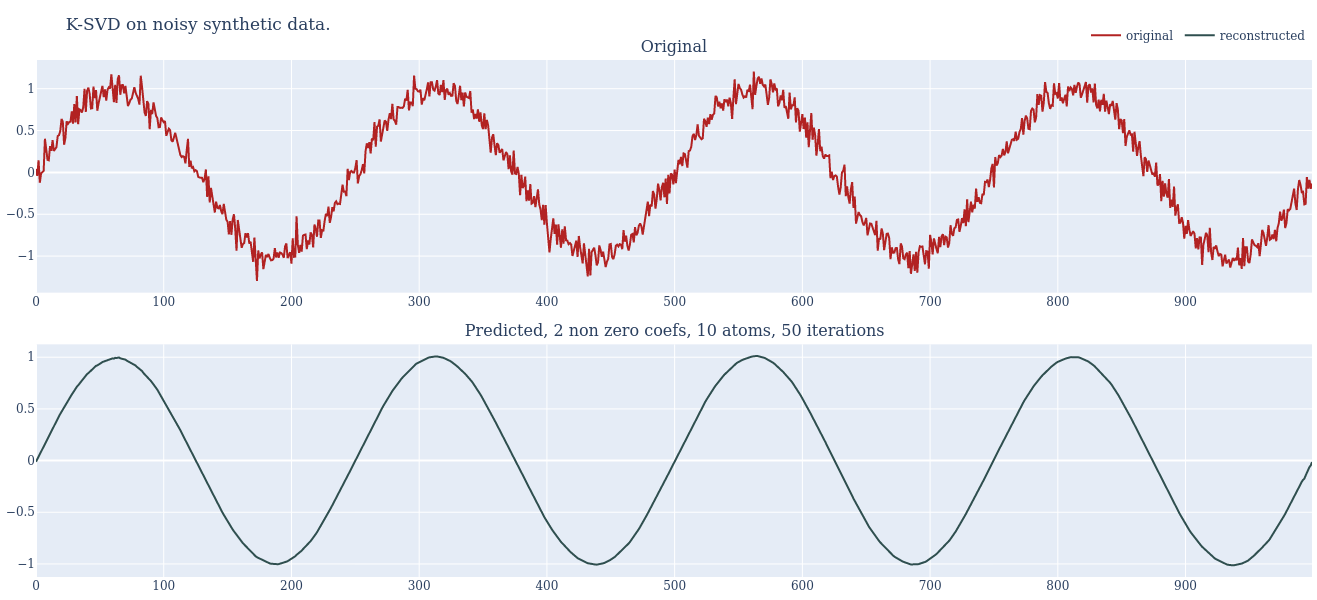

In [164]:
plot_original_pred(measure, pred, n_coefs=2, K=10, n_iter=max_iter, title="K-SVD on noisy synthetic data.")

## Convergence study

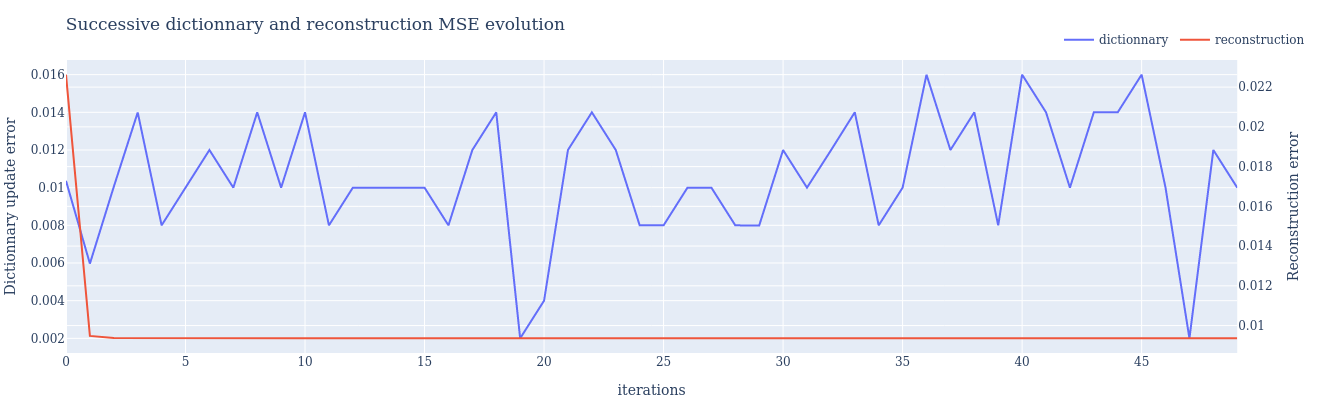

In [168]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
x_plot = np.arange(max_iter)
# Add traces
fig.add_trace(
    go.Scatter(x=x_plot, y=ksvd.dict_errors, name="dictionnary"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=x_plot, y=ksvd.reconstruction_errors, name="reconstruction"),
    secondary_y=True,
)


# Set x-axis title
fig.update_xaxes(title_text="iterations")

# Set y-axes titles
fig.update_yaxes(title_text="Dictionnary update error", secondary_y=False)
fig.update_yaxes(title_text="Reconstruction error", secondary_y=True)
fig.update_layout(
    margin={"t": 60, "b": 5, "r": 5, "l": 5},
    showlegend=True,
    font_family="Serif",
    title_text="Successive dictionnary and reconstruction MSE evolution",
    width=800,
    height=400,
    legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
    )
    )
fig.show()

## Denoising study

In [143]:
n_samples = 2048
tt = np.linspace(0, 1, n_samples)
signal = np.sqrt(tt * (1 - tt)) * np.sin((2.1 * np.pi) / (tt + .05))
signal /= signal.std()
rng = np.random.RandomState(0)
noise = 0.3 * rng.randn(*signal.shape)
snr = 20. * np.log10(signal.std() / noise.std())
measure = signal + noise

In [145]:
n_coefs = 5
K = 100
ksvd = KSVD(n_nonzero_coefs=n_coefs, K=K, max_iter=10, tol=1e-4)

D, Z = ksvd.fit_1d_signal(measure, 400)
pred = ksvd.predict_1d_signal(measure)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.33it/s]


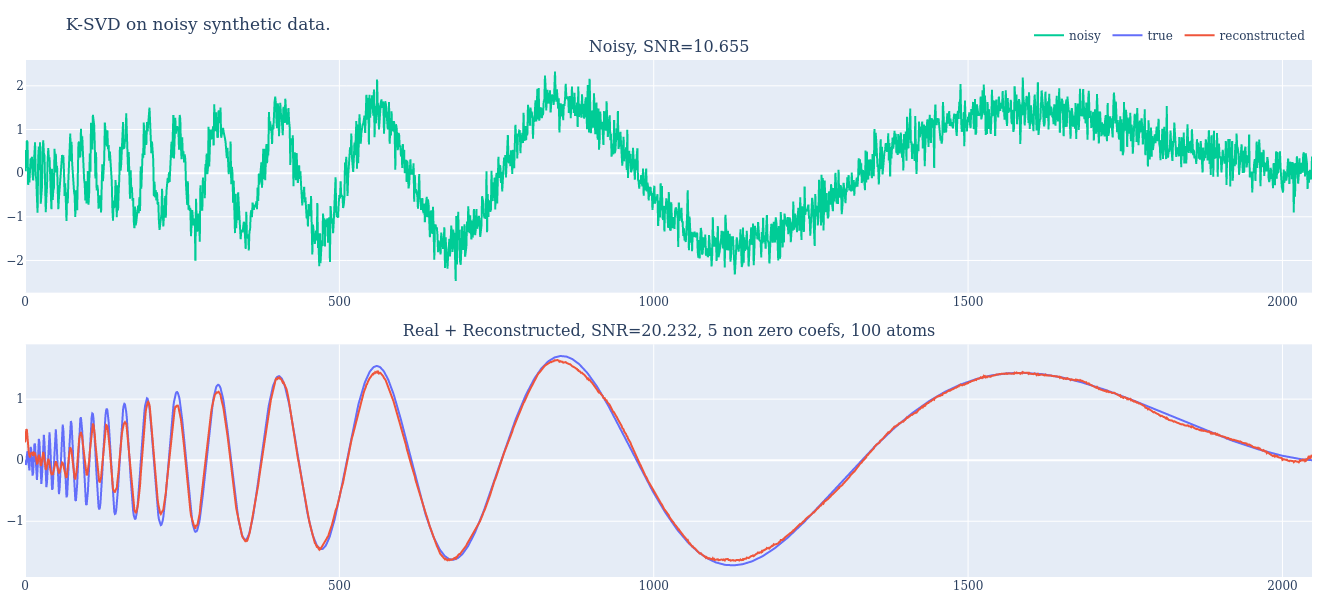

In [108]:
plot_real_noisy_pred(signal, measure, pred, n_coefs=n_coefs, K=K, title="K-SVD on noisy synthetic data.")

In [192]:
def build_predict(X, n_coefs, K, max_iter=3, N=400, jump=1, tol=1e-5, parellel=True):
    ksvd = KSVD(n_nonzero_coefs=n_coefs, K=K, max_iter=max_iter, tol=tol, parallel=Parallel)
    return ksvd.fit_predict_1d_signal(X, N, jump=jump)

def build_predict_snr(X_noisy, X_true, **kwargs):
    X_pred = build_predict(X_noisy, **kwargs)
    return SNR(X_true, X_pred)

In [185]:
from joblib import Parallel, delayed

In [220]:

n_coefs = 5
K = np.arange(10, 1000, 10)

In [194]:
n_coefs = np.arange(1, 100,)
K = 100
N = 400

n_coefs_snr = Parallel(n_jobs=-1)(delayed(build_predict_snr)(measure, signal, N=N, n_coefs=n, K=K, max_iter=3) for n in n_coefs) 

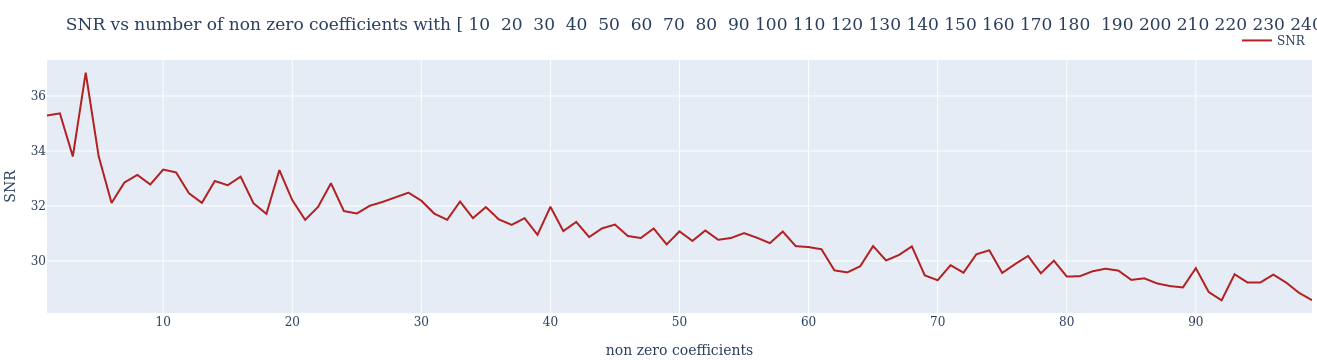

In [218]:
plot_line(x=n_coefs, y=n_coefs_snr, title=f'SNR vs number of non zero coefficients with {K} atoms', x_axes_title='non zero coefficients', y_axes_title='SNR', name='SNR')

In [214]:
n_coefs = 5
K = np.arange(10, 1000, 10)
N = 400

K_snr = Parallel(n_jobs=-1)(delayed(build_predict_snr)(measure, signal, N=N, n_coefs=n_coefs, K=k, max_iter=3) for k in K) 

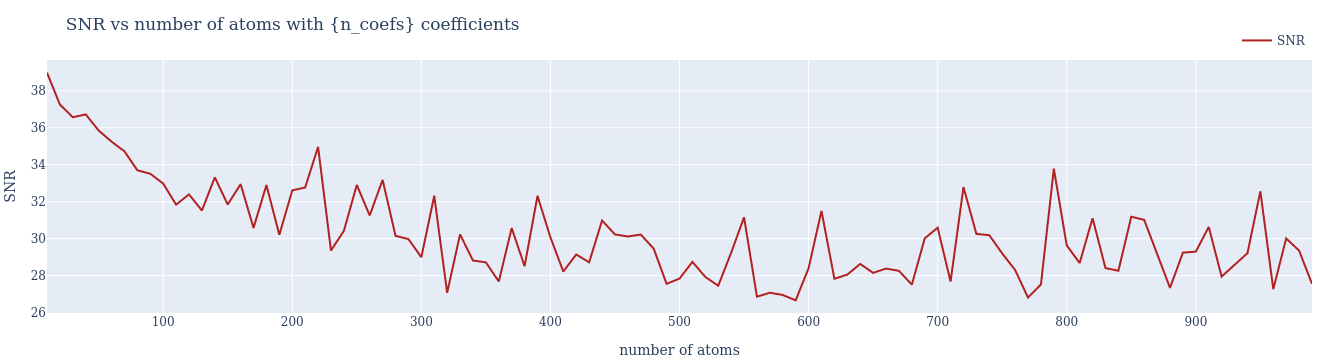

In [222]:
plot_line(x=K, y=K_snr, title='SNR vs number of atoms with {n_coefs} coefficients', x_axes_title='number of atoms', y_axes_title='SNR', name='SNR')

In [228]:
n_coefs = 5
K = 20
ksvd = KSVD(n_nonzero_coefs=n_coefs, K=K, max_iter=3, tol=1e-4)

D, Z = ksvd.fit_1d_signal(measure, 400)
pred = ksvd.predict_1d_signal(measure)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.80it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.51it/s]


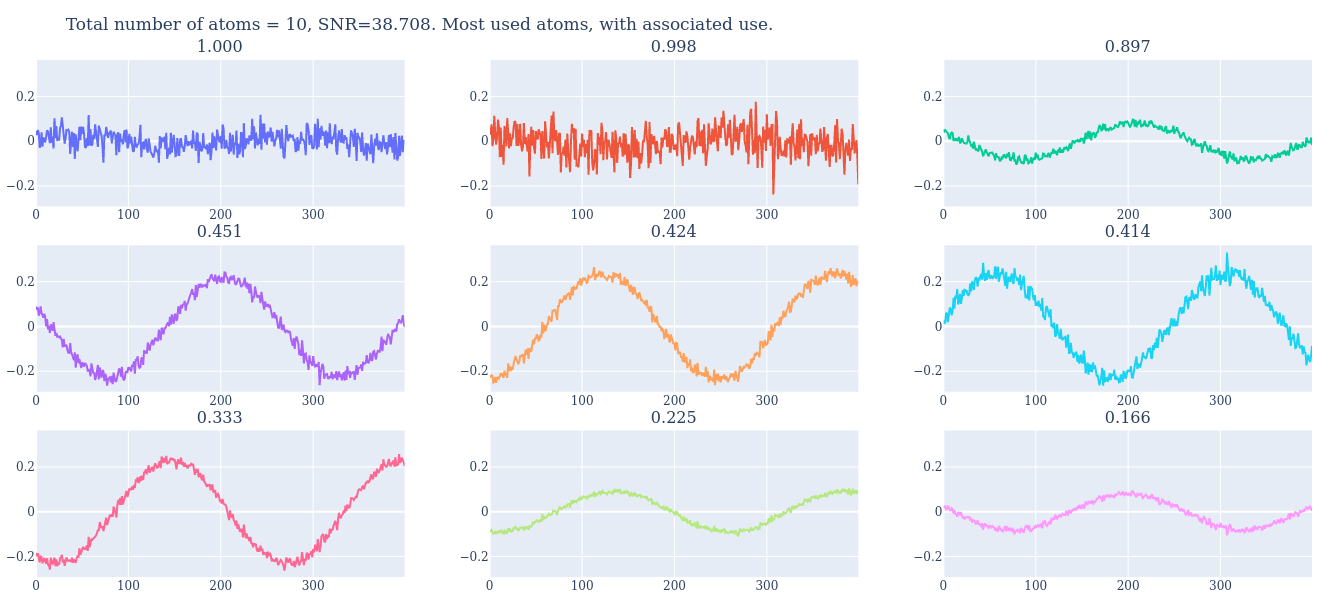

In [239]:
n_coefs = 5
K = 10
ksvd = KSVD(n_nonzero_coefs=n_coefs, K=K, max_iter=3, tol=1e-4)

D, Z = ksvd.fit_1d_signal(measure, 400)
pred = ksvd.predict_1d_signal(measure)
plot_atoms(D, Z, n_rows=3, vertical_spacing=.075, title=f'Total number of atoms = {K}, SNR={SNR(signal, pred):.3f}. Most used atoms, with associated use.')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.16it/s]


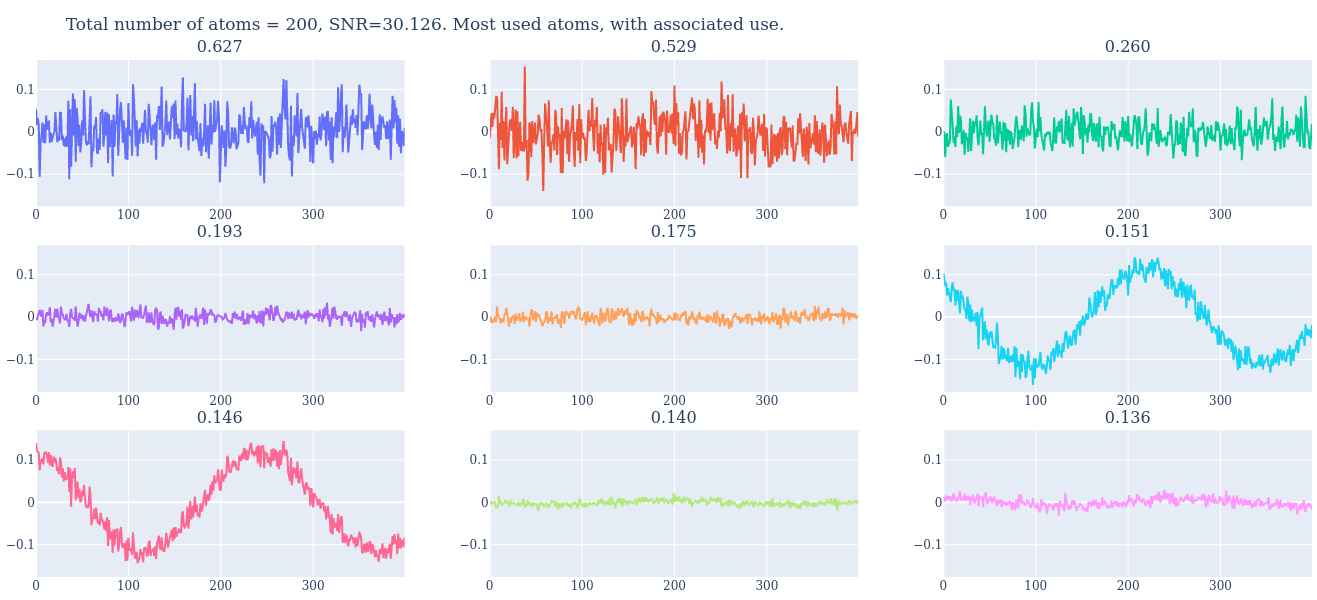

In [240]:
n_coefs = 5
K = 200
ksvd = KSVD(n_nonzero_coefs=n_coefs, K=K, max_iter=3, tol=1e-4)

D, Z = ksvd.fit_1d_signal(measure, 400)
pred = ksvd.predict_1d_signal(measure)
plot_atoms(D, Z, n_rows=3, vertical_spacing=.075, title=f'Total number of atoms = {K}, SNR={SNR(signal, pred):.3f}. Most used atoms, with associated use.')

# Real data

In [134]:
data_path = Path("./data/")
generation_data = data_path / "Plant_1_Generation_Data.csv"
df_generation = pd.read_csv(generation_data, index_col='DATE_TIME')
df_dc_power = df_generation[df_generation.SOURCE_KEY == "1BY6WEcLGh8j5v7"] # take the output of only one cell of the solar panel.
dc_power = df_dc_power.DC_POWER.to_numpy()

In [135]:
X_power = get_trajectory_matrix(dc_power, 400, jump=10)

In [204]:
K = 100
n_coefs = 5
ksvd = KSVD(n_nonzero_coefs=n_coefs, K=K, max_iter=5)
D, Z = ksvd.fit(X_power)

 20%|███████████████████████████████████▌                                                                                                                                              | 1/5 [00:00<00:01,  3.31it/s]


In [205]:
dc_reconstructed = reconstruct_signal(ksvd.predict(X_power), signal_length=dc_power.shape[0], jump=10)

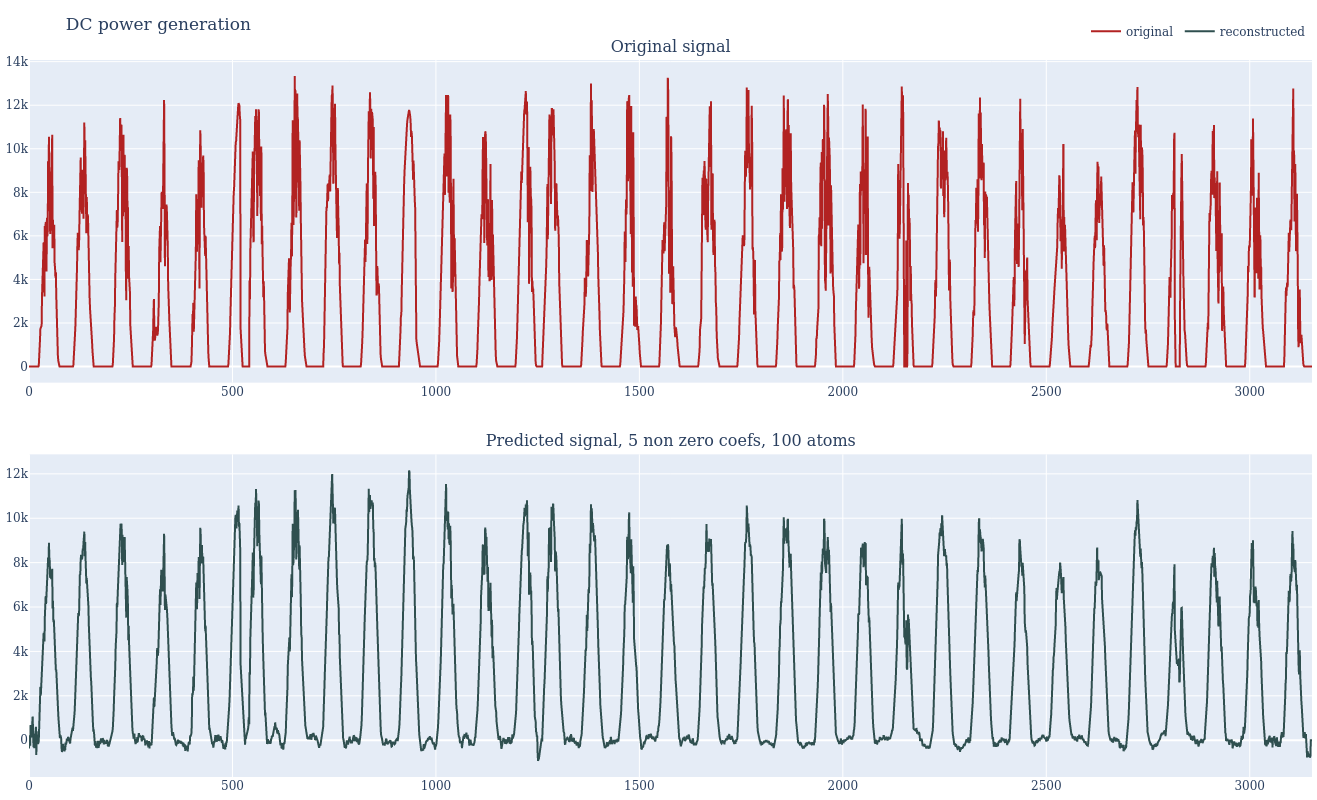

In [206]:
plot_original_pred(dc_power, dc_reconstructed, "DC power generation", n_coefs=n_coefs, K=K, height=800, vertical_spacing=.1)

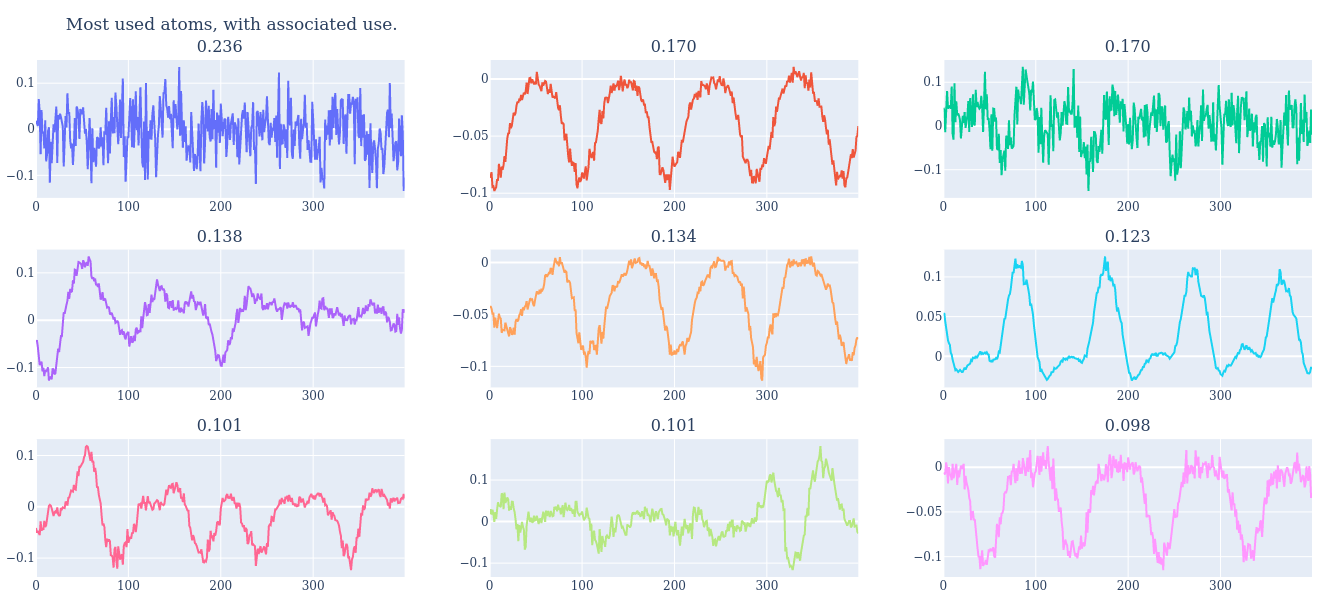

In [208]:
D_plot = plot_atoms(D, Z, n_rows=3)

((10, 276), (400, 10))

In [172]:
def plot_atoms(D, Z, figsize=(25, 10), n_rows=2):
    n_use = (Z != 0).sum(axis=1)
    ind_use_sort = np.argsort(n_use)[::-1]
    
    D_plot = D[:, ind_use_sort[:3 * n_rows]]
    
    fig, axs = plt.subplots(n_rows, 3, figsize=figsize)
    
    n_plot = 0
    for i in range(n_rows):
        for j in range(3):
            ax = axs[i, j]
            ax.plot(D_plot[:, n_plot])
            n_plot += 1
    
    plt.show()
    return D_plot
    

In [434]:
D_plot[:, 

(400, 9)